<a href="https://colab.research.google.com/github/DavidHernandez21/DavidHernandez21/blob/master/Copy_of_%5BMAKE_A_COPY%5D_Dialogflow_Intent_health_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to this Tutorial
The code that follows will walk you through several things:


1.   How to get programmatically use the the Dialogflow API and to interact with your agent programmatically
2.   How to use Tensorflow Hub to get start with Tensorflow Modules and how to use it to generate Embeddings for your training phrases
3.   Once the embeddings are created, how can we use them to detect problems in our Dialogflow agent.

Before starting, we need to install few dependencies

In [3]:
!pip install --quiet --upgrade tensorflow dialogflow scipy tensorflow-hub

     |████████████████████████████████| 327kB 2.9MB/s 


In [66]:
import dialogflow_v2 as dialogflow
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from collections import defaultdict
import os
from google.colab import auth
import pickle
print(tf.__version__)

2.2.0


Now, let's set the variables we need. These values should match the entried you used when creating a project and a service account

In [67]:
PROJECT_ID="prova-va-eni-dwpfjf" # Set your GCP Project Id
SERVICE_ACCOUNT_EMAIL="dialogflow-api-healthcheck@prova-va-eni-dwpfjf.iam.gserviceaccount.com" # Set your Dialogflow service account email

### Great
Now, we need to authenticate your session so you can create a key for your service account.

Follow the instructions in the output section of the cell below

In [68]:
auth.authenticate_user()
!gcloud config set project {PROJECT_ID}
!gcloud iam service-accounts keys create sa-key.json \
 --iam-account={SERVICE_ACCOUNT_EMAIL} --project={PROJECT_ID}

Updated property [core/project].
created key [5ec18937b65affa05817cb9d88f31b109eb29a71] of type [json] as [sa-key.json] for [dialogflow-api-healthcheck@prova-va-eni-dwpfjf.iam.gserviceaccount.com]


#### Let's take a snapshot of your Dialogflow account

The following code will issue two api calls to read the entities and the intents of your Dialogflow agent. We'll need these to perform our analysis

In [69]:
def fetch_intents_training_phrases(service_account_file, project):

  dialogflow_entity_client = dialogflow.EntityTypesClient.from_service_account_file(service_account_file)
  parent = dialogflow_entity_client.project_agent_path(project)
  entities = list(dialogflow_entity_client.list_entity_types(parent))

  dialogflow_intents_client = dialogflow.IntentsClient.from_service_account_file(service_account_file)
  parent = dialogflow_intents_client.project_agent_path(project)
  intents = list(dialogflow_intents_client.list_intents(
    parent=parent,
    intent_view=dialogflow.enums.IntentView.INTENT_VIEW_FULL))

  entities_name_to_value = {}
  for intent in intents:
      entities_used = {entity.display_name 
        for entity in intent.parameters}

      for entity in entities:
          if entity.display_name in entities_used \
                  and entity.display_name not in entities_name_to_value:
                  
              entities_name_to_value[entity.display_name] = np.random.choice(
                  np.random.choice(entity.entities).synonyms, replace=False)

  intent_training_phrases = defaultdict(list)
  for intent in intents:
      for training_phrase in intent.training_phrases:

          parts = [
              entities_name_to_value[part.alias] 
              if part.alias in  entities_name_to_value else part.text
              for part in training_phrase.parts
          ]
          intent_training_phrases[intent.display_name].append(
              "".join(parts))
      # Remove intents with no training phrases
      if not intent_training_phrases[intent.display_name]:
          del intent_training_phrases[intent.display_name]
  return intent_training_phrases


In [70]:
intent_training_phrases = fetch_intents_training_phrases("sa-key.json", PROJECT_ID)

for intent in intent_training_phrases:
  print("{}:{}".format(intent, intent_training_phrases[intent]))
  break

bollette_pagamenti:['Devo darvi altri soldi', 'Sono in arretrato di qualche bolletta', 'Mi sono dimenticato di pagare qualche bolletta', 'Vorrei sapere se per il numero cliente che ho digitato le fatture risultano tutte saldate', 'Volevo sapere a che punto sono i miei pagamenti', 'Buongiorno, vorrei conoscere lo stato dei miei pagamenti.', 'Ho delle bollette scadute?', 'Sì, ho pagato la bolletta, controlli?', 'Salve ho pagato la fattura luce con postepay tramite applicazione, ma non mi mostra se il pagamento sia andato a buon fine o meno, puo controllare?', 'Buongiorno, volevo sapere se ho qualche bolletta non pagata', 'vorrei sapere se ci sono delle fatture da pagare', 'Salve, può controllare se ho fatture scoperte, perchè sulla fattura appena ricevuta mi segnala una precedente fattura non pagata ma io le ho saldate tutte.', 'Vorrei sapere lo stato dei miei pagamenti, se ho qualche bolletta arretrata perchè non mi stanno arrivando le fatture', 'ho qualcosa indietro da pagare ?', 'vogl

### Let's create some embeddings

Embeddings are a projection of your data on a space with fewer dimensions
compared to the original space.

It is a lossy transformation and, in this case, we transform the training phrases into points in a space with 512 dimensions.

To do so, we'll use a Tensorflow hub module. [The universal sentence encoder](https://tfhub.dev/google/universal-sentence-encoder/2).

Before working on our data, let's see how it works.

Please note that for each new session the following code block can take a while to complete.
This is because for every session, Google Cloud provisions a new virtual machine, and we need to download the Tensorflow hub module. 


In [71]:
# tf.contrib.resampler
import tensorflow.compat.v1 as tf
#To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
tf.disable_eager_execution()

# !pip3 install tensorflow_text>=2.0.0rc0
import tensorflow_text

import shutil
if os.path.isdir('/tmp/tfhub_modules/97e68b633b7cf018904eb965602b92c9f3ad14c9'):
  shutil.rmtree('/tmp/tfhub_modules/97e68b633b7cf018904eb965602b92c9f3ad14c9')

# embed_module = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/2", name="usc2", trainable=True)
# https://tfhub.dev/google/universal-sentence-encoder-multilingual/3
# embed_module_2 = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-multilingual/2", name="usc9", trainable=True)
embed_module_1 = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

Now that we have the module and the Tensorflow operation defined, we can construct the first embeddings.

Before deep-diving in our Dialogflow's training phrases, let's analyze a small and simple synthetic example

In [72]:
def make_embeddings_fn():
  placeholder = tf.placeholder(dtype=tf.string, shape=[None])
  embed = embed_module_1(placeholder)
  session = tf.Session()
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  def _embeddings_fn(sentences):
      computed_embeddings = session.run(
        embed, feed_dict={placeholder: sentences})
      return computed_embeddings
  return _embeddings_fn

generate_embeddings = make_embeddings_fn()

In [77]:
sentences = [
  "donna",
  "uomo",
  "cane",
  "gatto"
]
computed_embeddings = generate_embeddings(sentences)
computed_embeddings

array([[-0.02529479,  0.01113481, -0.02789346, ..., -0.02214618,
         0.06132194, -0.0277035 ],
       [-0.03179109,  0.03381615, -0.04048672, ..., -0.04204452,
         0.04799779, -0.02861096],
       [ 0.01247474, -0.04704872, -0.01160761, ...,  0.00828644,
         0.05655241, -0.01926563],
       [ 0.05057176, -0.00646758, -0.01512738, ..., -0.00277747,
         0.06158425,  0.03345183]], dtype=float32)

Now you can see how the embeddings look like. Specifically, they are projections of the original sentences in a `512` dimensional space. This high-dimensional space is impossible to visualize for a human. So, let's project them to a 3-d space that we can visualize and comprehend.

To achieve this, we use Principal Component Analysis (PCA). PCA is a lossy transformation that conserves most of the variance in the data. This let's us plot the points in a 3d space while conserving the best we can the distance between the sentences.

Let's also print the relative distances between every point-pair.

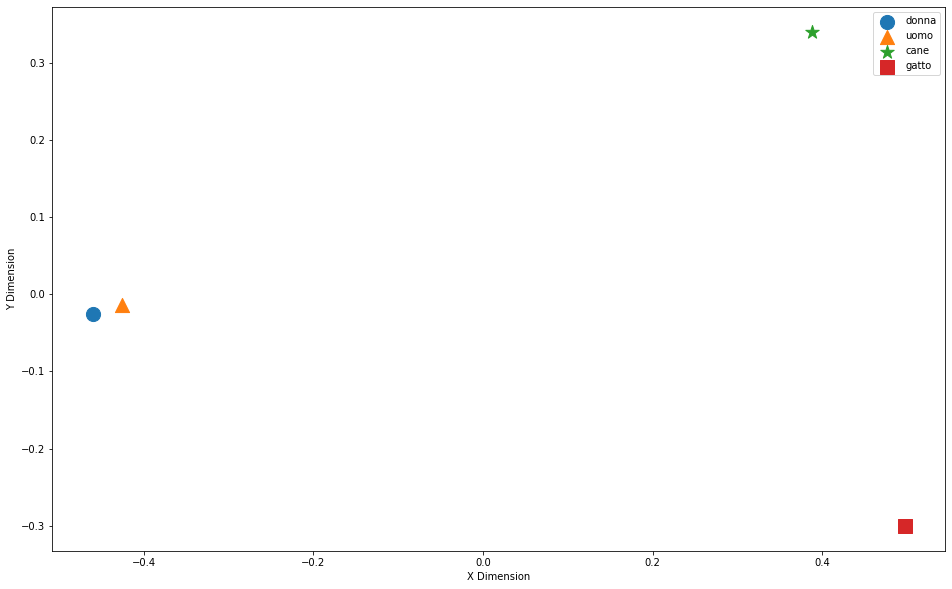

In [78]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import math

point_size=200

pca = PCA(n_components=2)
points_2d = pca.fit_transform(computed_embeddings)

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)

for point, marker in zip(points_2d, ['o', '^', '*', 's']):
  xs = point[0]
  ys = point[1]
  ax.scatter(xs, ys, marker=marker, s=point_size)

ax.set_xlabel('X Dimension')
ax.set_ylabel('Y Dimension')

ax.legend(sentences)
plt.show()

As you can see, our method seems to work. 'Hi' and 'Hello' are similar sentences, and hence they remain closer than any other pair of sentences in our simple example.

Let's now use this method to analyze our dialogflow training phrases

In [79]:
training_phrases_with_embeddings = defaultdict(list)
for intent_name, training_phrases_list in intent_training_phrases.items():
  computed_embeddings = generate_embeddings(training_phrases_list)
  training_phrases_with_embeddings[intent_name] = dict(zip(training_phrases_list, computed_embeddings))

In [80]:
for intent_name, _ in training_phrases_with_embeddings.items():
  training_phrase, embeddings = next(iter(training_phrases_with_embeddings[intent_name].items()))
  print("{}: {{'{}':{}}}".format(intent_name, training_phrase, embeddings[:5]))

bollette_pagamenti: {'Devo darvi altri soldi':[ 0.06491958 -0.023535    0.02221653 -0.05452812  0.05902265]}
domiciliazione: {'Vorrei informazioni sulla procedura SEPA':[-0.00939009  0.05910615  0.04919102  0.04874786  0.02182307]}
attivazione: {'ho preso casa da poco e il vecchio proprietario ha disattivato tutte le utenze, come faccio a riattivare la luce?':[-0.05933695 -0.00984779  0.03144694  0.01107333 -0.0572104 ]}
mancata_ricezione_fatturazione: {'Non mi è arrivata la bolletta':[-0.03005352 -0.04701748  0.01353724  0.0138259   0.00993949]}
NDS: {'Vorrei cambiare l'intestazione della polizza':[-0.01279142  0.08065911  0.00530914  0.03113386  0.02246702]}
stato_avanzamento_pratica: {'Come sta procedendo la mia richiesta di voltura':[-0.02651103  0.00709348  0.02875811  0.07169278 -0.04159699]}
accettazione_preventivo: {'Nell elenco dei costi previsti ci sono alcune voci che non sono giustificate':[-0.03280256  0.0287707   0.00650099 -0.02007826  0.05400737]}
cambio_intestazione: {

### Let's see how our training phrases are doing!


5


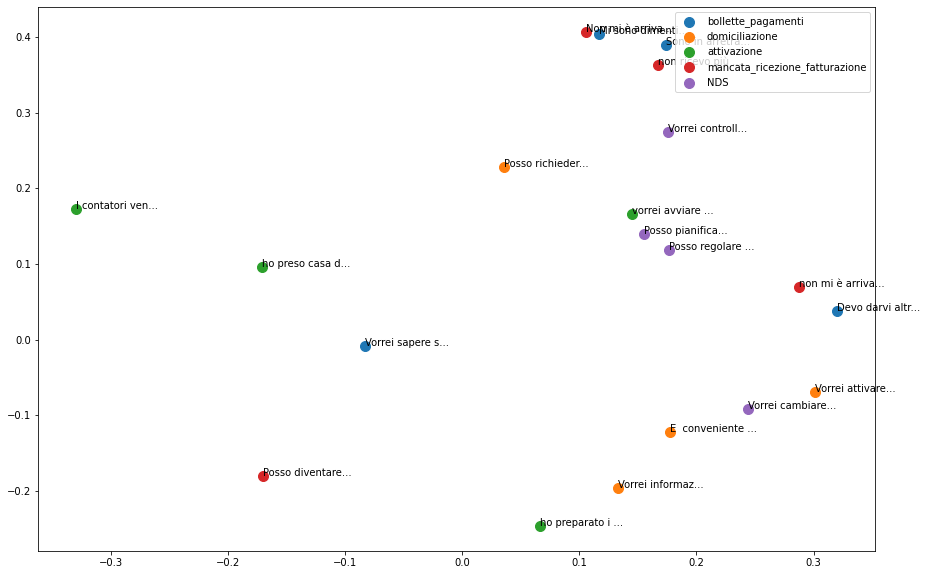

In [81]:
from sklearn.decomposition import PCA

embedding_vectors = []

for intent, training_phrases_and_embeddings in training_phrases_with_embeddings.items():
  for training_phrase, embeddings in training_phrases_and_embeddings.items():
    embedding_vectors.append(embeddings)

embedding_vectors = np.asarray(embedding_vectors)

pca = PCA(n_components=2)
pca.fit(embedding_vectors)

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

legend = []

index = 0

for color, intent in enumerate(training_phrases_with_embeddings.keys()):
  phrases = list(training_phrases_with_embeddings[intent].keys())[:4]
  embeddings = list(training_phrases_with_embeddings[intent].values())[:4]
  points = pca.transform(embeddings)
  xs = points[:,0]
  ys = points[:,1]
  ax.scatter(xs, ys, marker='o', s=100, c="C"+str(color))
  for i, phrase in enumerate(phrases):
    ax.annotate(phrase[:15] + '...', (xs[i], ys[i]))
  legend.append(intent)
  index += 1
  if index > 4:
    break

print(index)
ax.legend(legend)
plt.show()

### Cosine similarity
[Cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) is a similarity metric that scales well high-dimensional spaces. What it does is simple: given two vectors of numbers it calculates the cosine of angle between them.


![formula](https://wikimedia.org/api/rest_v1/media/math/render/svg/1d94e5903f7936d3c131e040ef2c51b473dd071d)

![](http://blog.christianperone.com/wp-content/uploads/2013/09/cosinesimilarityfq1.png)

To calculate this we can use `sklearn.metrics` package without coding it ourselves.


Before computing every possible pair of sentences, let's measure how *disperse* are our intents.

In [82]:
from sklearn.metrics.pairwise import cosine_similarity      

flatten = []

for intent in training_phrases_with_embeddings:
  for phrase in training_phrases_with_embeddings[intent]:
    flatten.append((intent, phrase,  training_phrases_with_embeddings[intent][phrase]))

data = []
for i in range(len(flatten)):
  for j in range(i+1, len(flatten)):

    intent_1 = flatten[i][0]
    phrase_1 = flatten[i][1]
    embedd_1 = flatten[i][2]

    intent_2 = flatten[j][0]
    phrase_2 = flatten[j][1]
    embedd_2 = flatten[j][2]

    similarity = cosine_similarity([embedd_1], [embedd_2])[0][0]

    record = [intent_1, phrase_1, intent_2, phrase_2, similarity]
    data.append(record)

similarity_df = pd.DataFrame(data, 
  columns=["Intent A", "Phrase A", "Intent B", "Phrase B", "Similarity"])

In [83]:
different_intent = similarity_df['Intent A'] != similarity_df['Intent B']
similarity_df_not_1 = similarity_df[(similarity_df["Similarity"] < .99) & (similarity_df["Intent A"] != similarity_df["Intent B"])]
# similarity_df_not_1.head(1)
# np.sort(np.unique(similarity_df_not_1["Similarity"]))[-1]
display(similarity_df_not_1.sort_values('Similarity', ascending=False).head(10))

,Intent A,Phrase A,Intent B,Phrase B,Similarity
2903660,attivazione,Quanto ci vorrà per l'attivazione?,stato_avanzamento_pratica,Quanto tempo ci vorrà per la attivazione?,0.978517
650140,bollette_pagamenti,Posso pagare a rate la bolletta?,rateizzazione,Ma posso pagare in bolletta le rate?,0.965222
731607,bollette_pagamenti,Ho ricevuto un sms ma io non ho la bolletta,mancata_ricezione_fatturazione,mi è arrivato un sms ma io non ho quella bolletta,0.958516
2507224,attivazione,dovrei aprire il contatore del gas,contratto,devo chiudere il contatore del gas,0.956150
3186157,attivazione,I tempi di attivazione?,offerte_passaggio,Quali sono i tempi di attivazione?,0.954960
2927280,attivazione,Quali sono i tempi necessari per l'attivazione?,offerte_passaggio,Quali sono i tempi di attivazione?,0.950161
5688902,stato_avanzamento_pratica,Quando sarà attiva la mia fornitura?,accettazione_preventivo,Quando sarà attiva la fornitura?,0.949775
3491166,attivazione,devo far aprire il contatore,contratto,devo chiudere il contatore,0.938211
7548686,contratto,Possibile?,rateizzazione,E' possibile?,0.936670
3517681,attivazione,vorrei riattivare un contatore,contratto,Voglio riattivare il contatore,0.935605


### Compute Intents Cohesion

In [61]:
same_intent = similarity_df['Intent A'] == similarity_df['Intent B']
cohesion_df = pd.DataFrame(similarity_df[same_intent].groupby('Intent A', as_index=False)['Similarity'].mean())
cohesion_df.columns = ['Intent', 'Cohesion']
display(cohesion_df.sort_values("Cohesion"))

,Intent,Cohesion
8,contratto,0.228834
1,NDS,0.231879
11,offerte_passaggio,0.241051
14,stato_avanzamento_pratica,0.251992
4,autolettura,0.255320
5,bollette_generico,0.281105
7,cambio_intestazione,0.297251
3,attivazione,0.325159
9,domiciliazione,0.346311
2,accettazione_preventivo,0.381202


In [63]:
different_intent = similarity_df['Intent A'] != similarity_df['Intent B']
separation_df = pd.DataFrame(similarity_df[different_intent].groupby(['Intent A', 'Intent B'], as_index=False)['Similarity'].mean())
separation_df['Separation'] = 1 - separation_df['Similarity']
del separation_df['Similarity']
display(separation_df.sort_values('Separation')[:5])

,Intent A,Intent B,Separation
50,bollette_pagamenti,mancata_ricezione_fatturazione,0.651321
53,bollette_pagamenti,rateizzazione,0.669629
85,mancata_ricezione_fatturazione,rateizzazione,0.684165
39,bollette_generico,rateizzazione,0.692595
36,bollette_generico,mancata_ricezione_fatturazione,0.695527


## License

Authors:  Marcello Stiner & Khalid Salama

---
**Disclaimer**: This is not an official Google product. The sample code provided for an educational purpose.

---

Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0.

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---
